![](https://i.imgur.com/ROxK2Zl.jpeg)

Dirk Rossmann GmbH, commonly refered to as Rossmann, is one of the largest drug store chains in Europe, operates over 3,000 drug stores in 7 Europe countries. In this project, we will discover the company's historical sales and turn these business insight into actionable business strategy for the company.On the top of that, we will know how to use the historical data to forecast the sales of the company.

#### A description of each of the columns of the datasets are provided below:
- Id - an Id that represents a (Store, Date) duple within the test set.
- Store - a unique Id for each store.
- Sales - the turnover for any given day (this is what we are predicting).
- Customers - the number of customers on a given day.
- Open - an indicator for whether the store was open: 0 = closed, 1 = open.
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None.
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools.
- StoreType - differentiates between 4 different store models: a, b, c, d.
- Assortment - describes an assortment level: a = basic, b = extra, c = extended.
- CompetitionDistance - distance in meters to the nearest competitor store.
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened.
- Promo - indicates whether a store is running a promo on that day.
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating.
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2.
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store.

# I. IMPORT DATA

In [2]:
# Import libraries

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

import datetime
from scipy import stats as stats
import inflection

import xgboost as xgb

import statsmodels as sm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, RobustScaler, MinMaxScaler, StandardScaler, Normalizer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

import pmdarima as pm

import math
from math import sqrt

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Read csv files
store = pd.read_csv('Datasets/store.csv')
train = pd.read_csv('Datasets/train.csv')

In [4]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [6]:
# Merge store and train
data = pd.merge(store, train, how = 'left', on = 'Store')
data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,5,2015-07-31,5263,555,1,1,0,1
1,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,4,2015-07-30,5020,546,1,1,0,1
2,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,3,2015-07-29,4782,523,1,1,0,1
3,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2,2015-07-28,5011,560,1,1,0,1
4,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,1,2015-07-27,6102,612,1,1,0,1


# II. DATA CLEANING

## 2.1. Filling missing data

In [7]:
# Missing values and missing values percentage
def missing_percentage(df):
    total = df.isnull().sum().sort_values(ascending = False)[df.isnull().sum().sort_values(ascending = False) != 0]
    percentage = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100, 2)[round(df.isnull().sum().sort_values(ascending = False)/len(df)*100, 2) != 0]
    return pd.concat([total, percentage], axis = 1, keys = ['Total', 'Percentage'])

In [8]:
missing_percentage(data)

,Total,Percentage
PromoInterval,508031,49.94
Promo2SinceWeek,508031,49.94
Promo2SinceYear,508031,49.94
CompetitionOpenSinceMonth,323348,31.79
CompetitionOpenSinceYear,323348,31.79
CompetitionDistance,2642,0.26


We can see that some features have a high percentage of missing values and they won't be accurate as indicators, so we will remove features with more than 30% missing values.

In [9]:
# Drop unnecessary columns
data = data.drop(['PromoInterval', 'Promo2SinceWeek', 'Promo2SinceYear', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear'], axis = 1)

In [10]:
# Fulfill missing values with suitable values (in this case : median)
data['CompetitionDistance'].fillna(data['CompetitionDistance'].median(), inplace = True)

In [11]:
missing_percentage(data)

,Total,Percentage


## 2.2. Data Type Correction

In [12]:
data.dtypes

Store                    int64
StoreType               object
Assortment              object
CompetitionDistance    float64
Promo2                   int64
DayOfWeek                int64
Date                    object
Sales                    int64
Customers                int64
Open                     int64
Promo                    int64
StateHoliday            object
SchoolHoliday            int64
dtype: object

In [13]:
# Change data type
data['Date'] = pd.to_datetime(data['Date'])
data['CompetitionDistance'] = data['CompetitionDistance'].astype('int')

In [14]:
# Map month name with number
month_name = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May', 
             6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}
data['month_name'] = data['Date'].dt.month.map(month_name)


In [15]:
# Insert new column year_month having only the month and year
data['year_month'] = data['Date'].dt.year.astype('str') + '-' + data['Date'].dt.month.astype('str')
data['year_month'] = pd.to_datetime(data['year_month'])
data['year_month']

0         2015-07-01
1         2015-07-01
2         2015-07-01
3         2015-07-01
4         2015-07-01
             ...    
1017204   2013-01-01
1017205   2013-01-01
1017206   2013-01-01
1017207   2013-01-01
1017208   2013-01-01
Name: year_month, Length: 1017209, dtype: datetime64[ns]

In [16]:
data['StateHoliday'].value_counts()

0    855087
0    131072
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [17]:
# Replace the value 0 (int) with the value 0 (str)
data['StateHoliday'].replace(0, '0', inplace = True)

## 2.3. Rename columns

In [18]:
data.columns.to_list()

['Store',
 'StoreType',
 'Assortment',
 'CompetitionDistance',
 'Promo2',
 'DayOfWeek',
 'Date',
 'Sales',
 'Customers',
 'Open',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'month_name',
 'year_month']

In [19]:

old_cols = ['Store', 'StoreType', 'Assortment', 'CompetitionDistance', 'Promo2',
            'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'month_name', 'year_month']
new_cols = list(map(lambda x: inflection.underscore(x), old_cols))

data.columns = new_cols

## 2.4. Feature engineering

In [20]:
data2 = data.copy()

In [21]:
data2.head()

,store,store_type,assortment,competition_distance,promo2,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,month_name,year_month
0,1,c,a,1270,0,5,2015-07-31,5263,555,1,1,0,1,Jul,2015-07-01
1,1,c,a,1270,0,4,2015-07-30,5020,546,1,1,0,1,Jul,2015-07-01
2,1,c,a,1270,0,3,2015-07-29,4782,523,1,1,0,1,Jul,2015-07-01
3,1,c,a,1270,0,2,2015-07-28,5011,560,1,1,0,1,Jul,2015-07-01
4,1,c,a,1270,0,1,2015-07-27,6102,612,1,1,0,1,Jul,2015-07-01


In [22]:
# Year
data2['year'] = data2['date'].dt.year

# Month
data2['month'] = data2['date'].dt.month

# Day
data2['day'] = data2['date'].dt.day

# Week of year
data2['week_of_year'] = data2['date'].dt.isocalendar().week
data2['week_of_year'] = data2['week_of_year'].astype(int)

# Year week
data2['year_week'] = data2['date'].dt.strftime('%Y-%W')

# Assortment
data2['assortment'] = data2['assortment'].map({'a' : 'basic', 'b' : 'extra', 'c' : 'extended'})

# state holiday
data2['state_holiday'] = data2['state_holiday'].map({'a' : 'public_holiday', 'b' : 'easter_holiday', 'c' : 'christmas', '0' : 'regular_day'})


In [23]:
data2.head().T

,0,1,2,3,4
store,1,1,1,1,1
store_type,c,c,c,c,c
assortment,basic,basic,basic,basic,basic
competition_distance,1270,1270,1270,1270,1270
promo2,0,0,0,0,0
day_of_week,5,4,3,2,1
date,2015-07-31 00:00:00,2015-07-30 00:00:00,2015-07-29 00:00:00,2015-07-28 00:00:00,2015-07-27 00:00:00
sales,5263,5020,4782,5011,6102
customers,555,546,523,560,612
open,1,1,1,1,1


## 2.5. Filter of variables

In [24]:
# Make a copy of data2
data3 = data2.copy()

In [25]:
# Select only necessary columns
data3 = data3[(data3['open'] != 0) & (data3['sales'] > 0)]

cols_to_drop = ['open', 'month_name']
data3 = data3.drop(cols_to_drop, axis = 1)

# III. EXPLORATORY DATA ANALYSIS

In [26]:
data4 = data3.copy()

##### Goals of EDA
1. Gain business experience
2. Validate business hypothesis (business insights)
3. Variables that are important to the model


## 3.1. Overall

### 3.1.1. Target variable

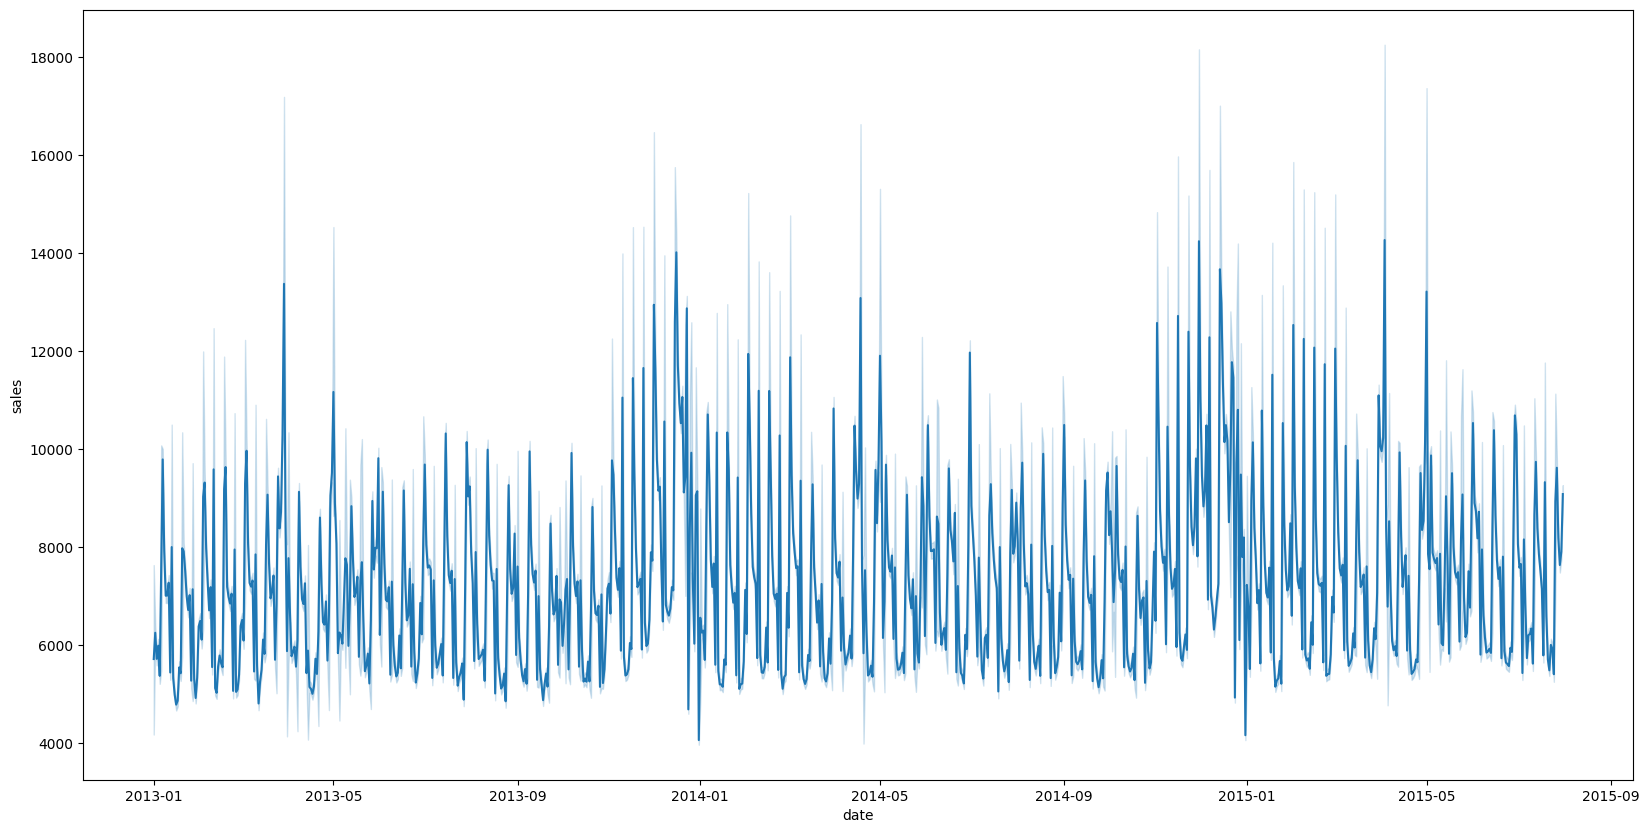

In [27]:
plt.figure(figsize = (20, 10))
sns.lineplot(data = data4, x = 'date', y = 'sales')
plt.show()

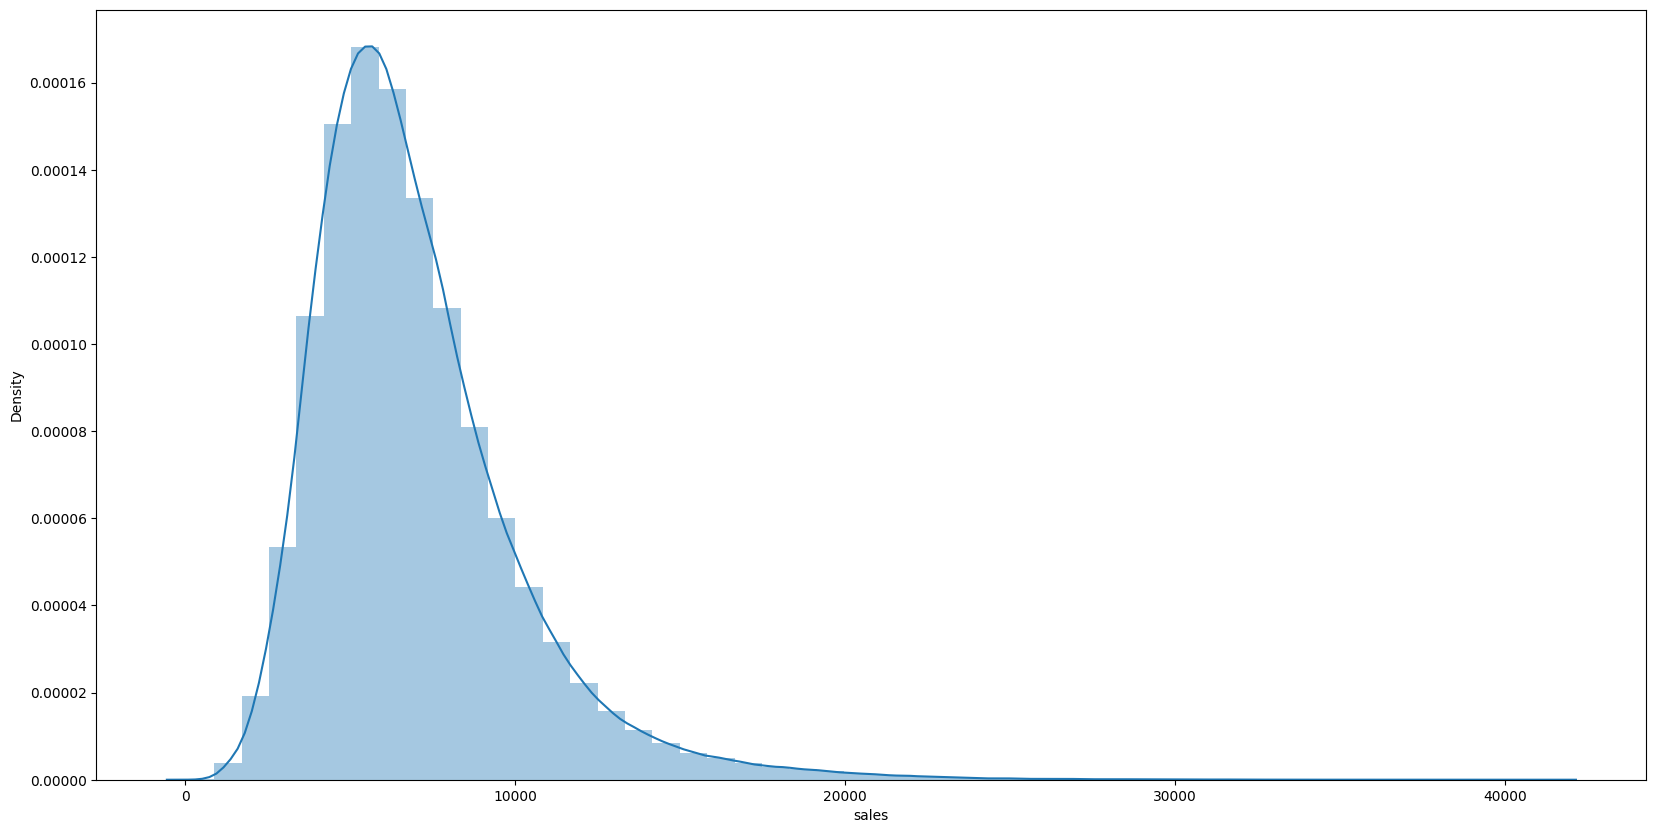

In [28]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.distplot(data4['sales'], kde = True, ax = ax)
plt.show()

### 3.1.2. Numerical variables

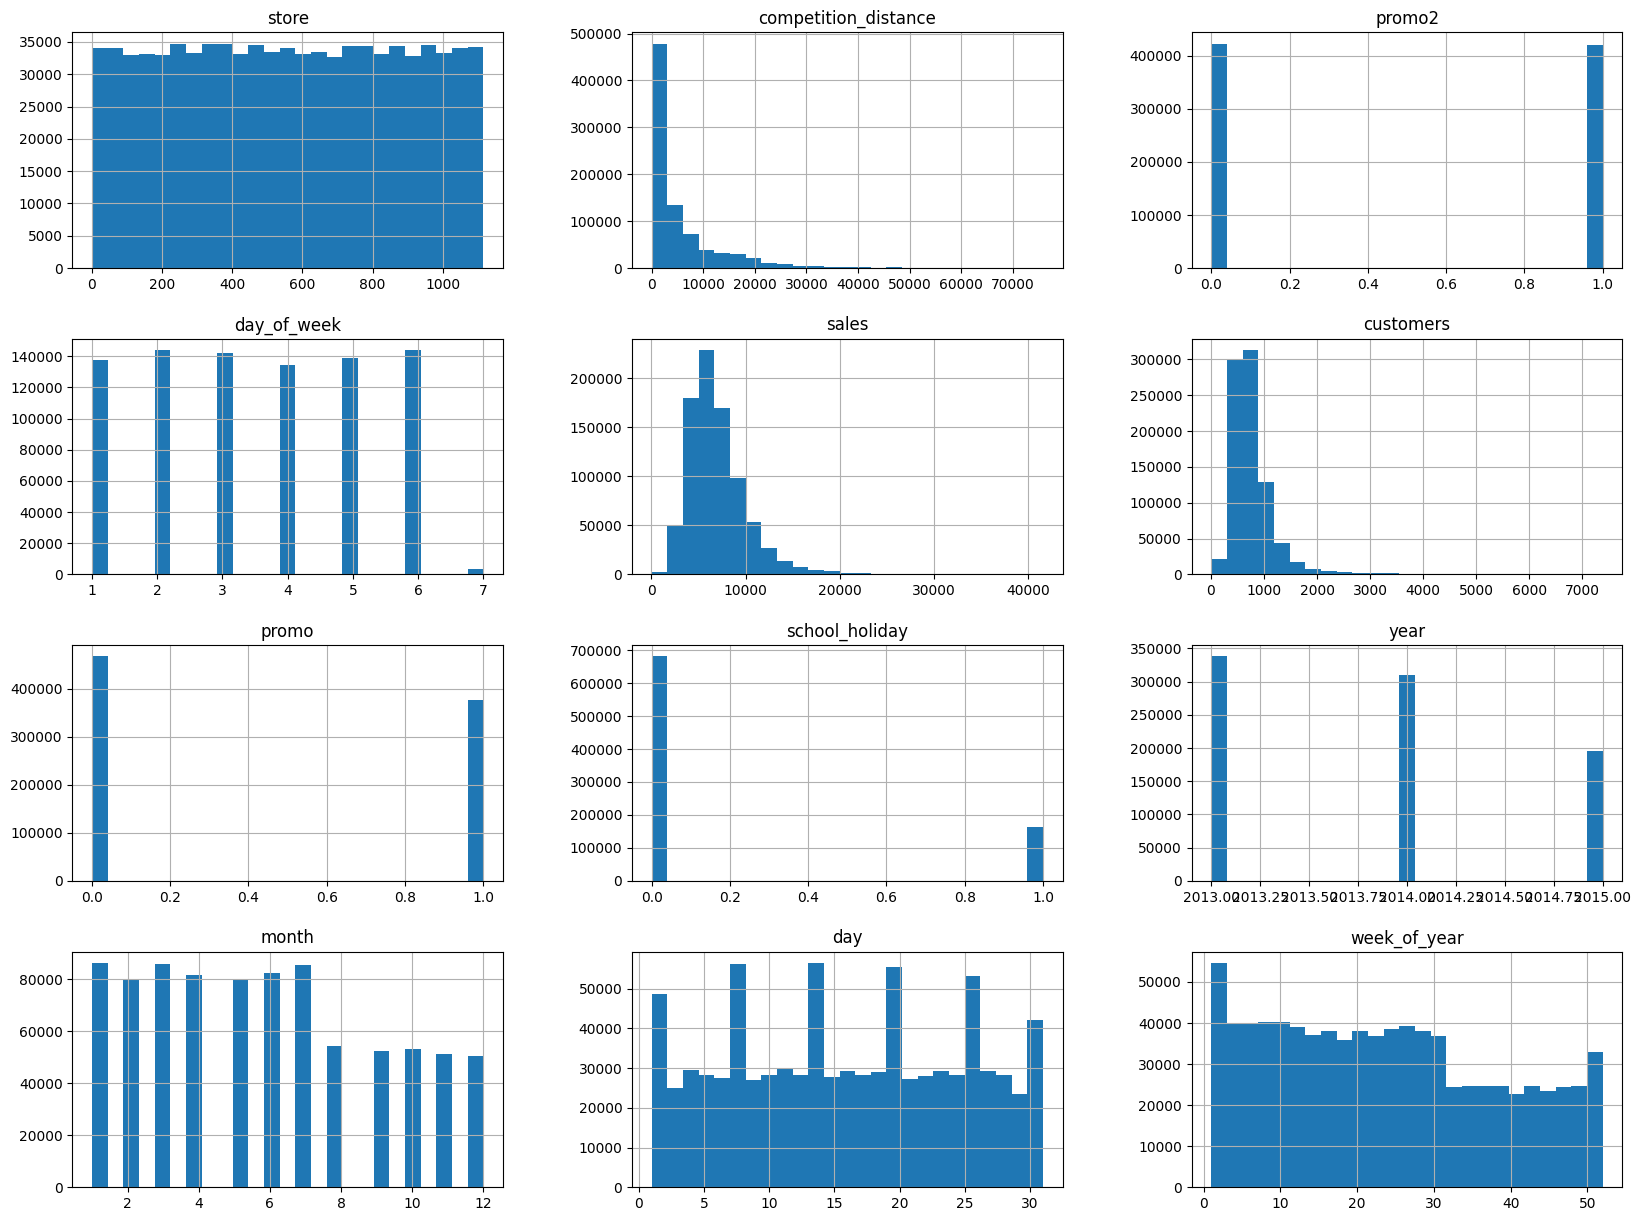

In [29]:
num_att = data4.select_dtypes(include = ['int32', 'int64'])

num_att.hist(bins = 25, figsize = (20, 15));
plt.show();

### 3.1.3. Categorical variables

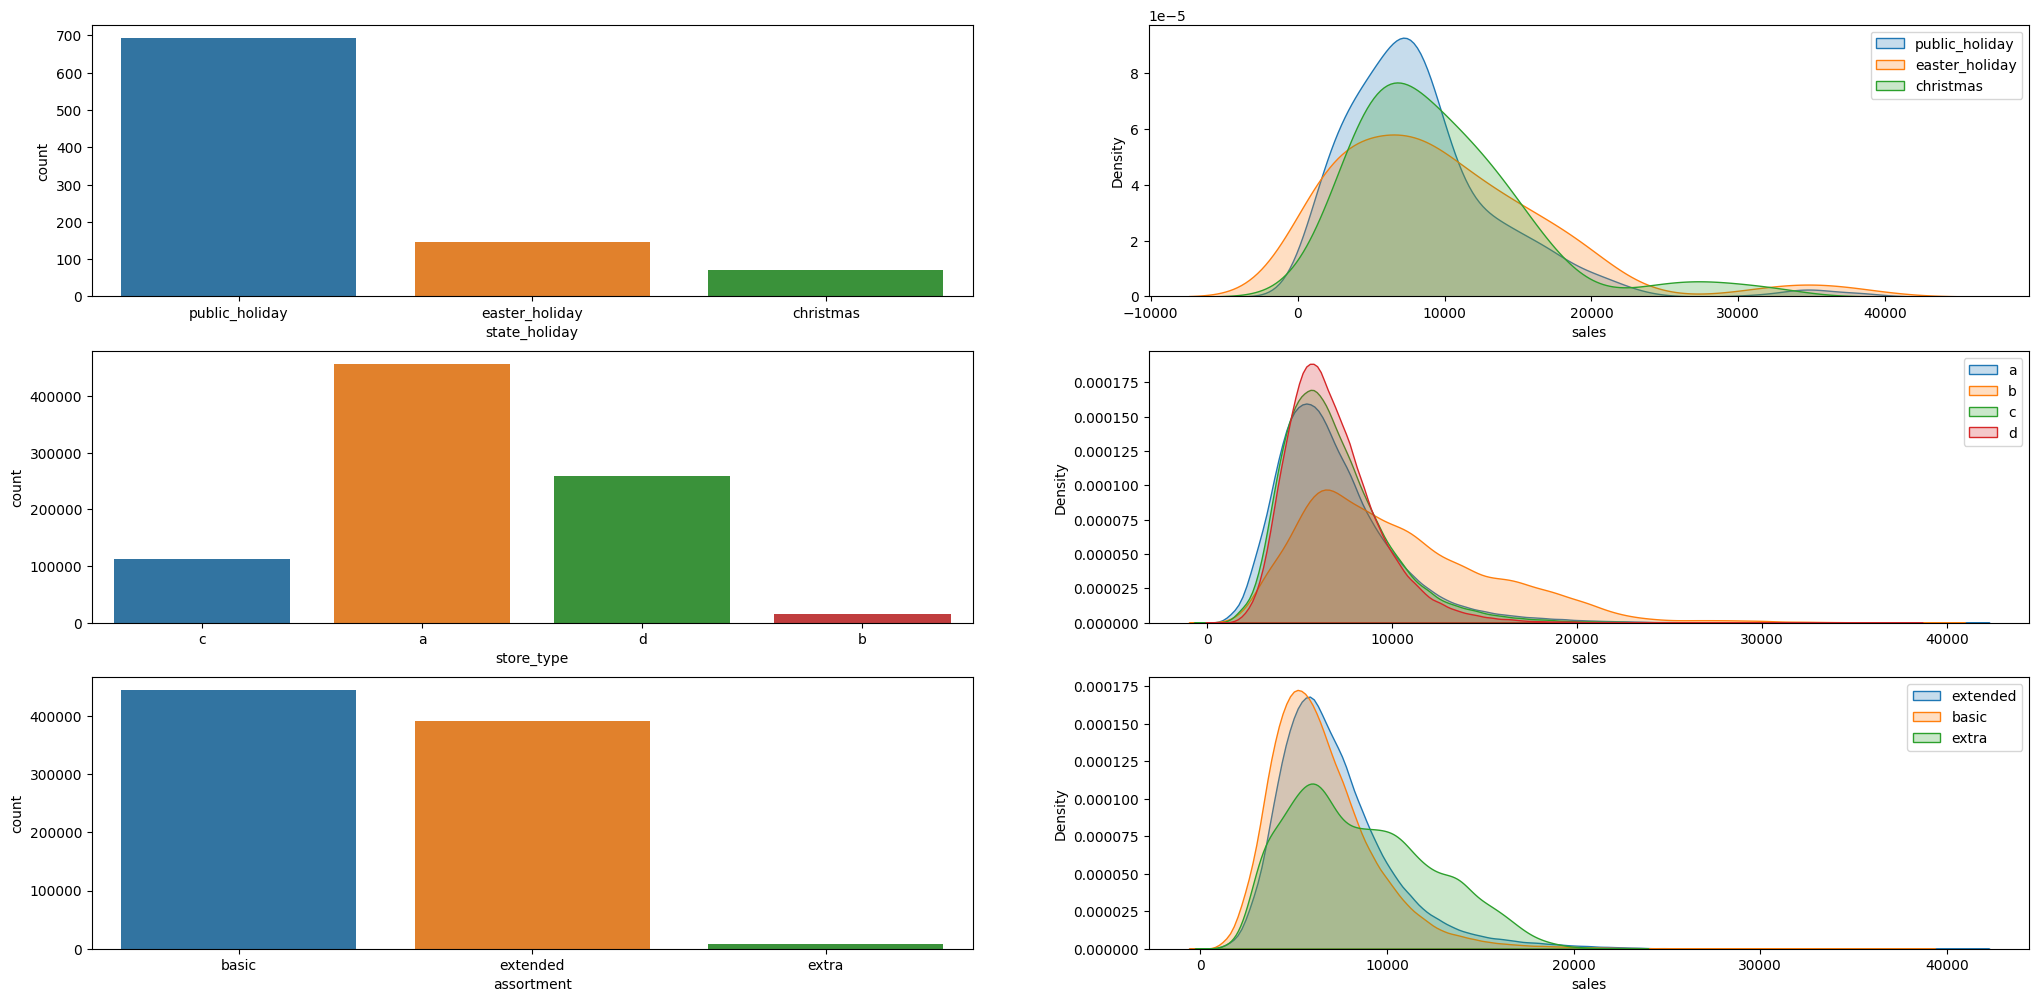

In [30]:
cat_att = data4.select_dtypes(exclude = ['int32', 'int64', 'datetime64[ns]'])

plt.figure(figsize = (25, 12))

# Holiday state
plt.subplot(3, 2, 1)
sns.countplot(data = data4[data4['state_holiday'] != 'regular_day'], x = 'state_holiday')

plt.subplot(3, 2, 2)
sns.kdeplot(data4[data4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade = True)
sns.kdeplot(data4[data4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade = True)
sns.kdeplot(data4[data4['state_holiday'] == 'christmas']['sales'], label = 'christmas', shade = True)
plt.legend()

# Store type
plt.subplot(3, 2, 3)
sns.countplot(data = data4, x = 'store_type')

plt.subplot(3, 2, 4)
sns.kdeplot(data4[data4['store_type'] == 'a']['sales'], label = 'a', shade = True)
sns.kdeplot(data4[data4['store_type'] == 'b']['sales'], label = 'b', shade = True)
sns.kdeplot(data4[data4['store_type'] == 'c']['sales'], label = 'c', shade = True)
sns.kdeplot(data4[data4['store_type'] == 'd']['sales'], label = 'd', shade = True)
plt.legend()

# Assortment
plt.subplot(3, 2, 5)
sns.countplot(data = data4, x = 'assortment')

plt.subplot(3, 2, 6)
sns.kdeplot(data4[data4['assortment'] == 'extended']['sales'], label = 'extended', shade = True)
sns.kdeplot(data4[data4['assortment'] == 'basic']['sales'], label = 'basic', shade = True)
sns.kdeplot(data4[data4['assortment'] == 'extra']['sales'], label = 'extra', shade = True)
plt.legend()

plt.show()

## 3.2. EDA - Store Type

In [31]:
data4['avg_sales_per_customer'] = data4['sales']/data4['customers']

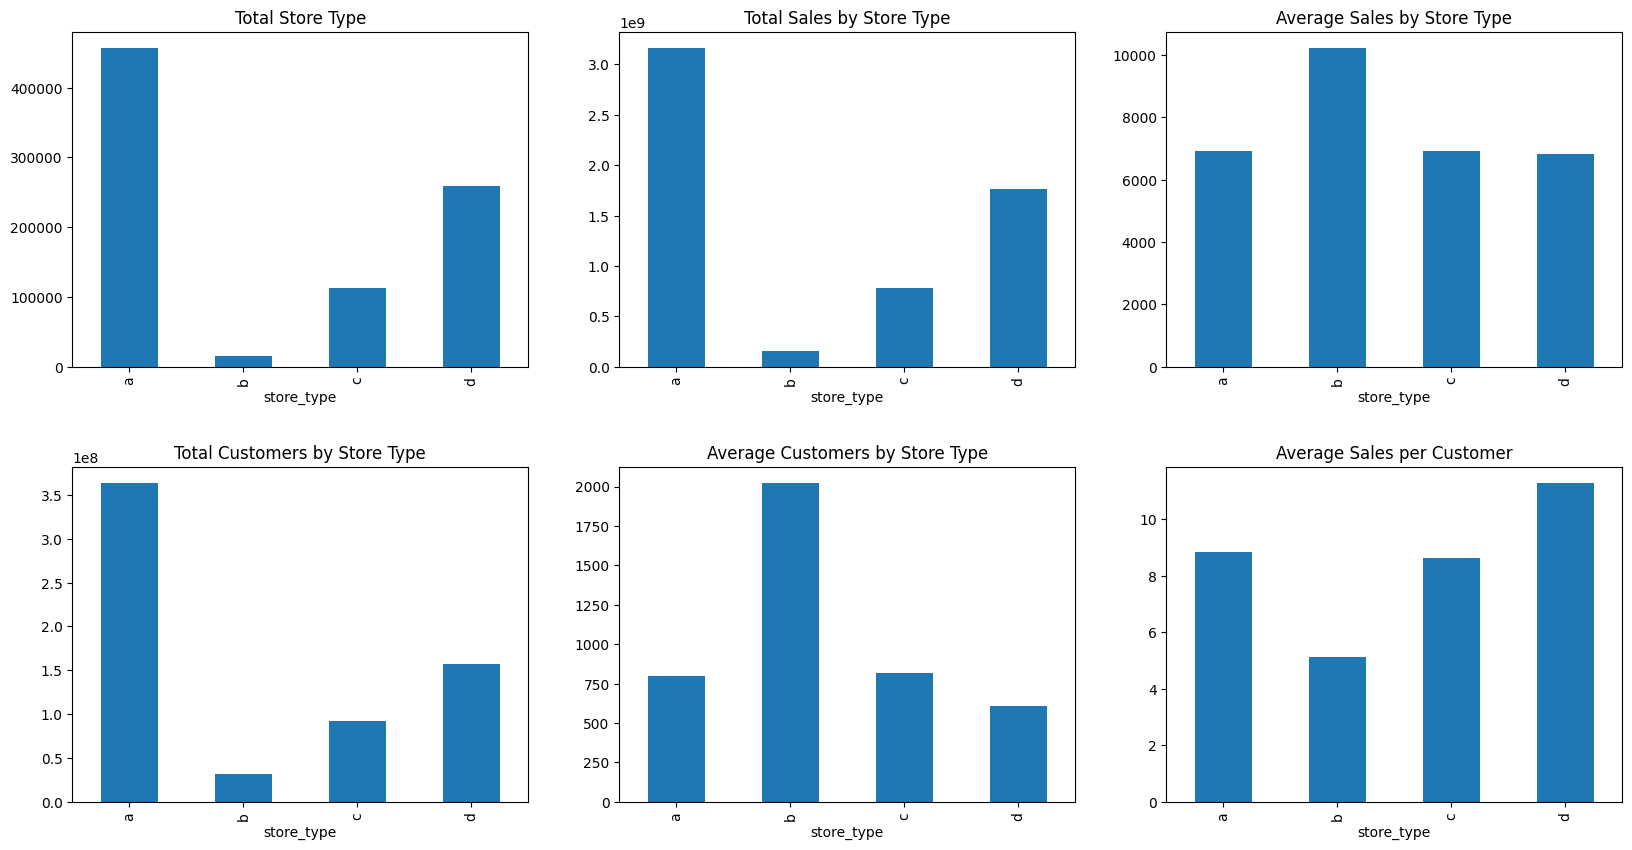

In [32]:
fig, ax = plt.subplots(2, 3, figsize = (20, 10))
ax.ravel()

data4.groupby('store_type')['store'].count().plot(kind = 'bar', title = 'Total Store Type', ax = ax[0, 0])
data4.groupby('store_type')['sales'].sum().plot(kind = 'bar', title = 'Total Sales by Store Type', ax = ax[0, 1])
data4.groupby('store_type')['sales'].mean().plot(kind = 'bar', title = 'Average Sales by Store Type', ax = ax[0, 2])
data4.groupby('store_type')['customers'].sum().plot(kind = 'bar', title = 'Total Customers by Store Type', ax = ax[1, 0])
data4.groupby('store_type')['customers'].mean().plot(kind = 'bar', title = 'Average Customers by Store Type', ax = ax[1, 1])
data4.groupby('store_type')['avg_sales_per_customer'].mean().plot(kind = 'bar', title = 'Average Sales per Customer')

plt.subplots_adjust(hspace = 0.3)
plt.show()

The store_type A has the most stores, sales and customers. However the store_type B has the most average sales and average customers. Besides, the store_type D has the best average sales per customers.

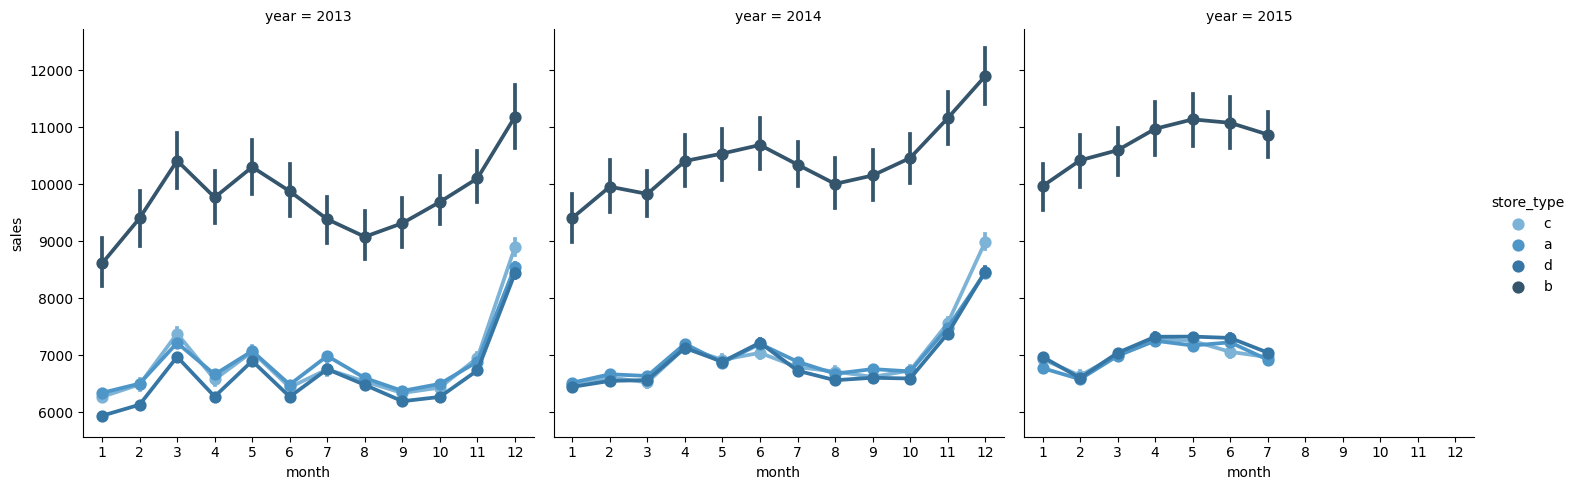

In [33]:

sns.catplot(data = data4, x = 'month', y = 'sales', col = 'year', hue = 'store_type', kind = 'point', palette = 'Blues_d');

Over the years, the store_type B always has the best average sales every month. The remaining stores have quite similar amount of sales.

## 3.3. EDA - Promotion

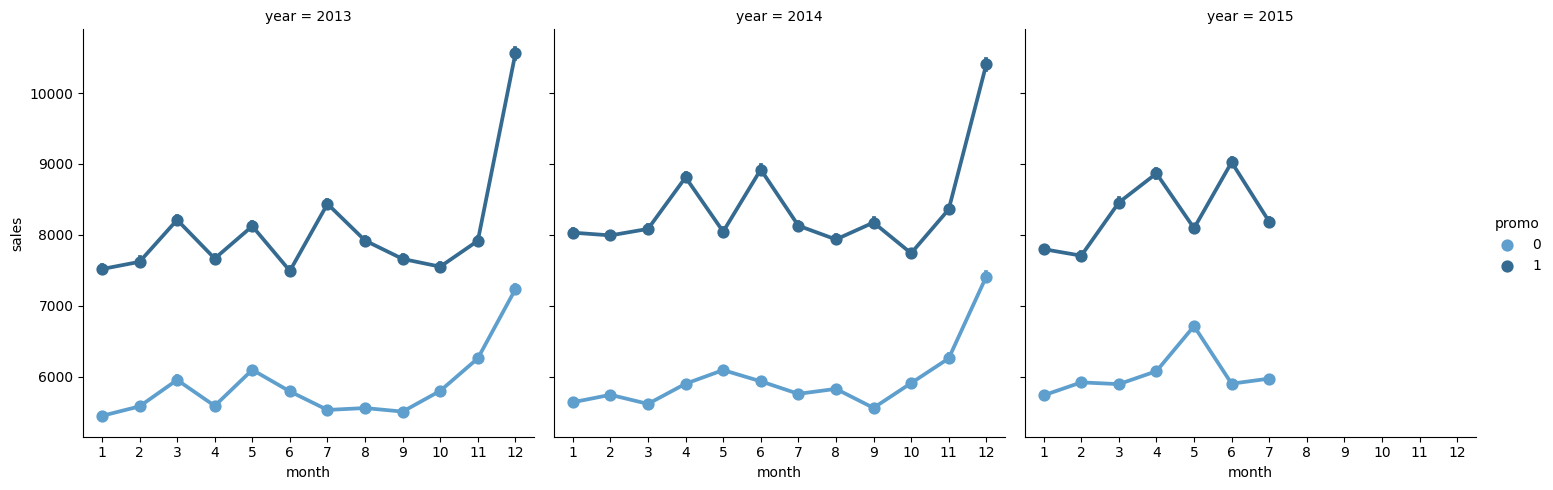

In [34]:
sns.catplot(data = data4, x = 'month', y = 'sales', col = 'year', hue = 'promo', kind = 'point', palette = 'Blues_d');

As we can see, the sales are higher when the promo is running. 

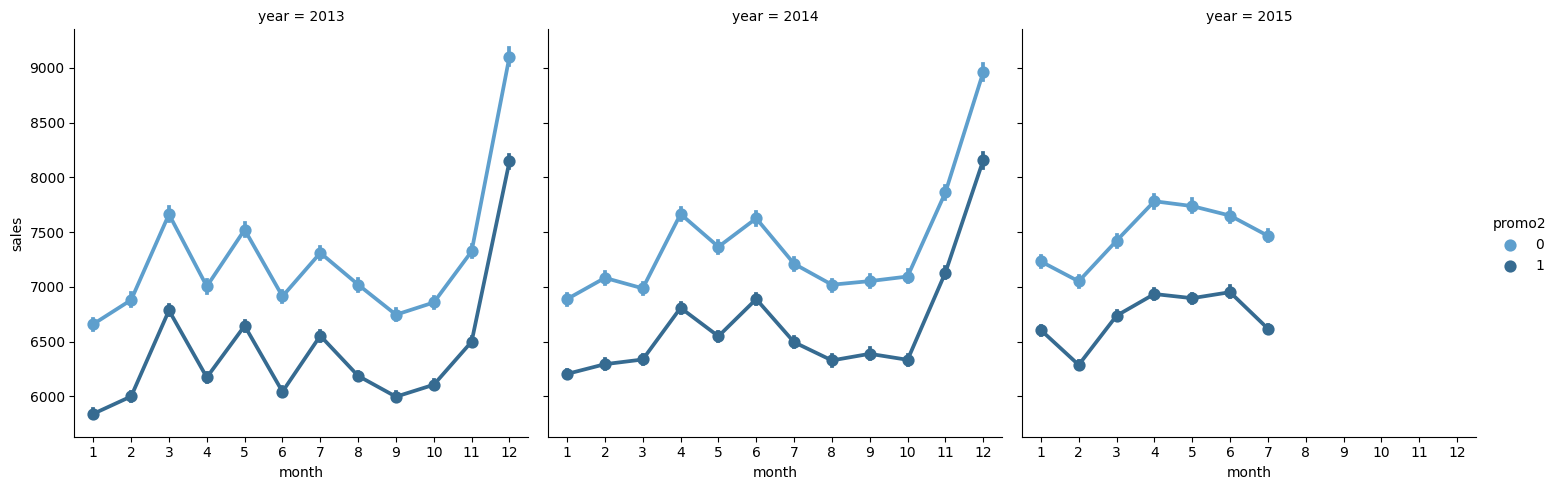

In [35]:
sns.catplot(data = data4, x = 'month', y = 'sales', col = 'year', hue = 'promo2', kind = 'point', palette = 'Blues_d');

However, stores that have a higher amount of extended promotions tend to sell less, on average, compared to stores that only feature the traditional promotion.
Sales under the traditional promotion alone have always been equally higher than sales under the traditional and extended promotions at the same time during the period available in the dataset.

## 3.4. EDA - Assortment Type

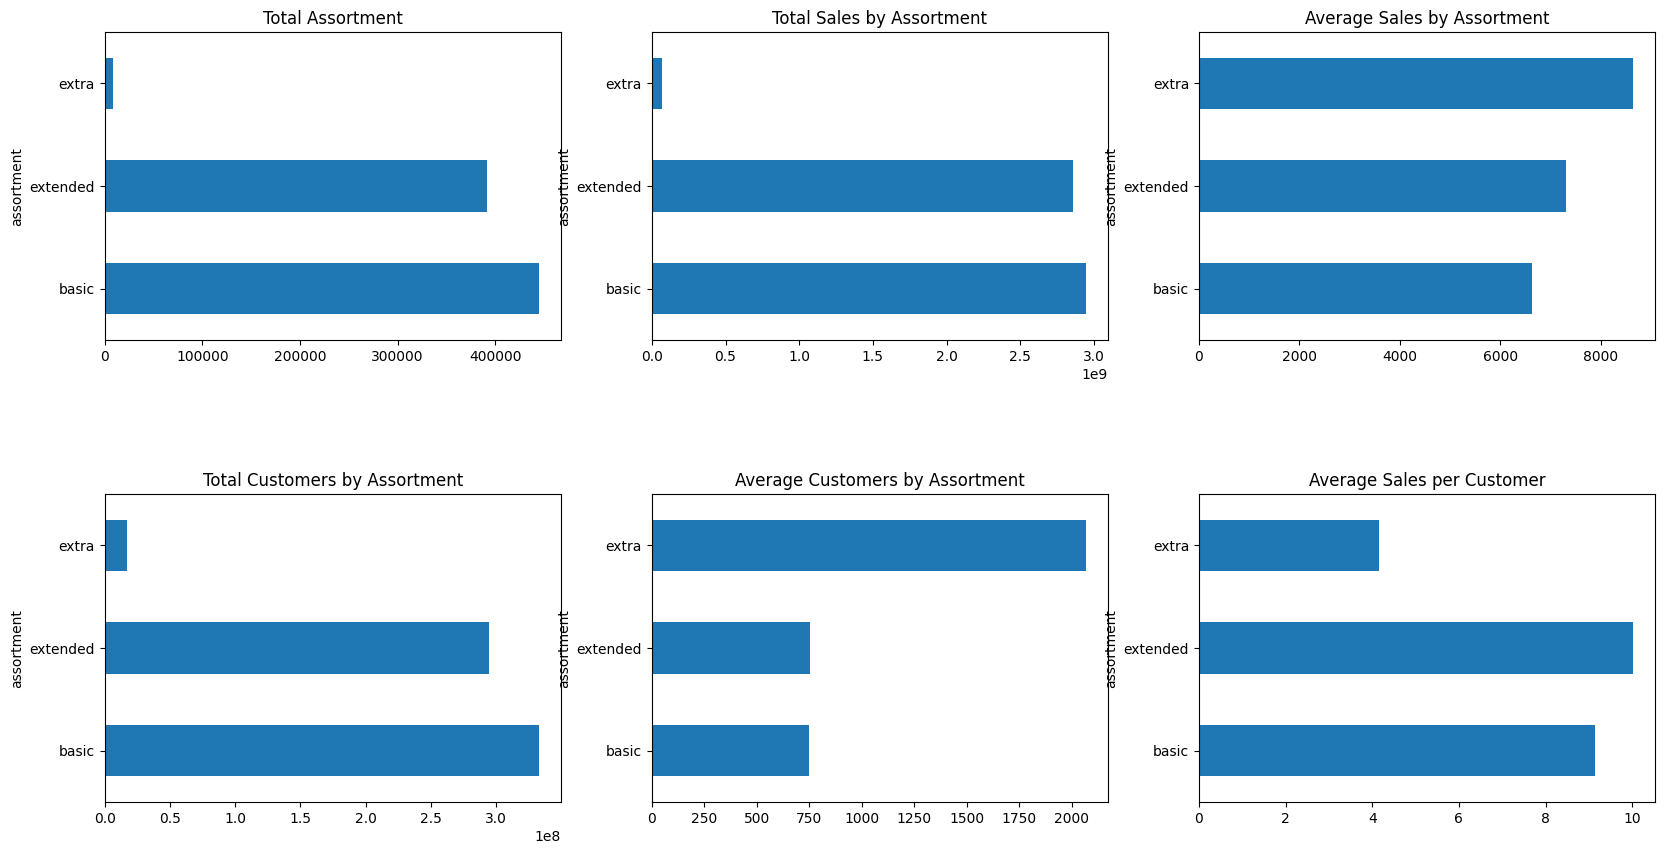

In [36]:
fig, ax = plt.subplots(2, 3, figsize = (20, 10))
ax.ravel()

data4.groupby('assortment')['store'].count().plot(kind = 'barh', title = 'Total Assortment', ax = ax[0, 0])
data4.groupby('assortment')['sales'].sum().plot(kind = 'barh', title = 'Total Sales by Assortment', ax = ax[0, 1])
data4.groupby('assortment')['sales'].mean().plot(kind = 'barh', title = 'Average Sales by Assortment', ax = ax[0, 2])
data4.groupby('assortment')['customers'].sum().plot(kind = 'barh', title = 'Total Customers by Assortment', ax = ax[1, 0])
data4.groupby('assortment')['customers'].mean().plot(kind = 'barh', title = 'Average Customers by Assortment', ax = ax[1, 1])
data4.groupby('assortment')['avg_sales_per_customer'].mean().plot(kind = 'barh', title = 'Average Sales per Customer')

plt.subplots_adjust(hspace = 0.5)
plt.show()

The extra type has a small amount compare to other assortment types. Store with larger assortment tend to sell more.

## 3.5. EDA - Sales and Customers

In [37]:
data4['day_of_week'] = data4['day_of_week'] + 1

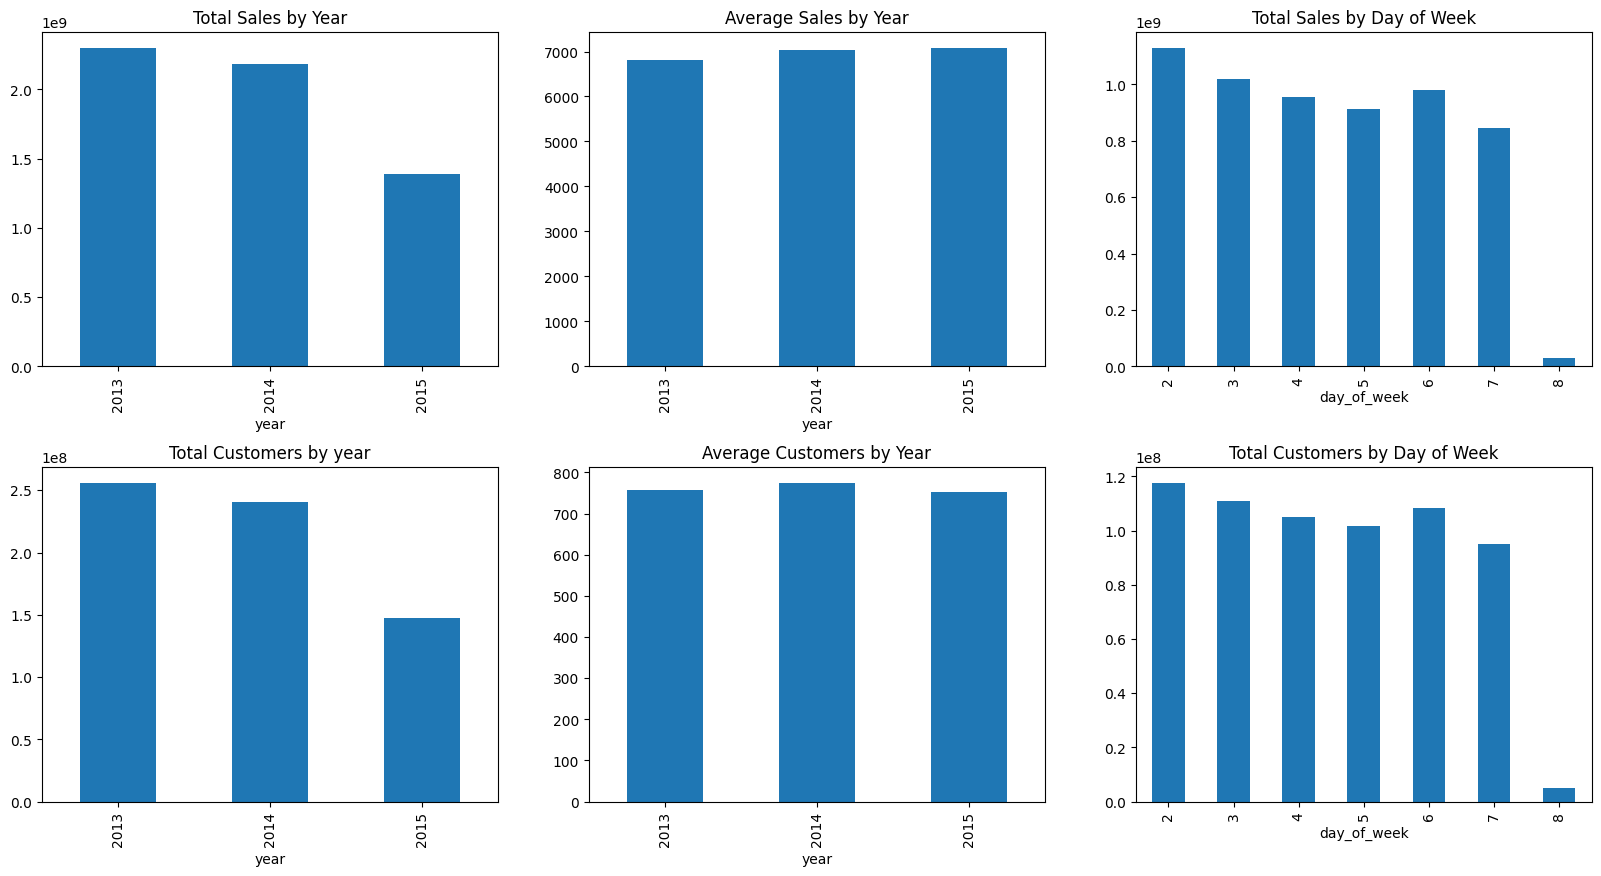

In [38]:
fig, ax = plt.subplots(2, 3, figsize = (20, 10))
ax.ravel()

data4.groupby('year')['sales'].sum().plot(kind = 'bar', title = 'Total Sales by Year', ax = ax[0, 0])
data4.groupby('year')['sales'].mean().plot(kind = 'bar', title = 'Average Sales by Year', ax = ax[0, 1])
data4.groupby('day_of_week')['sales'].sum().plot(kind = 'bar', title = 'Total Sales by Day of Week', ax = ax[0, 2])

data4.groupby('year')['customers'].sum().plot(kind = 'bar', title = 'Total Customers by year', ax = ax[1, 0])
data4.groupby('year')['customers'].mean().plot(kind = 'bar', title = 'Average Customers by Year', ax = ax[1, 1])
data4.groupby('day_of_week')['customers'].sum().plot(kind = 'bar', title = 'Total Customers by Day of Week', ax = ax[1, 2])

plt.subplots_adjust(hspace = 0.3)
plt.show()

Compare to 2013, total sales decrease by 5.3% in 2014. In the other hand, average sales by year keep increasing from 2013. Consumers not tend to purchase on Sunday.

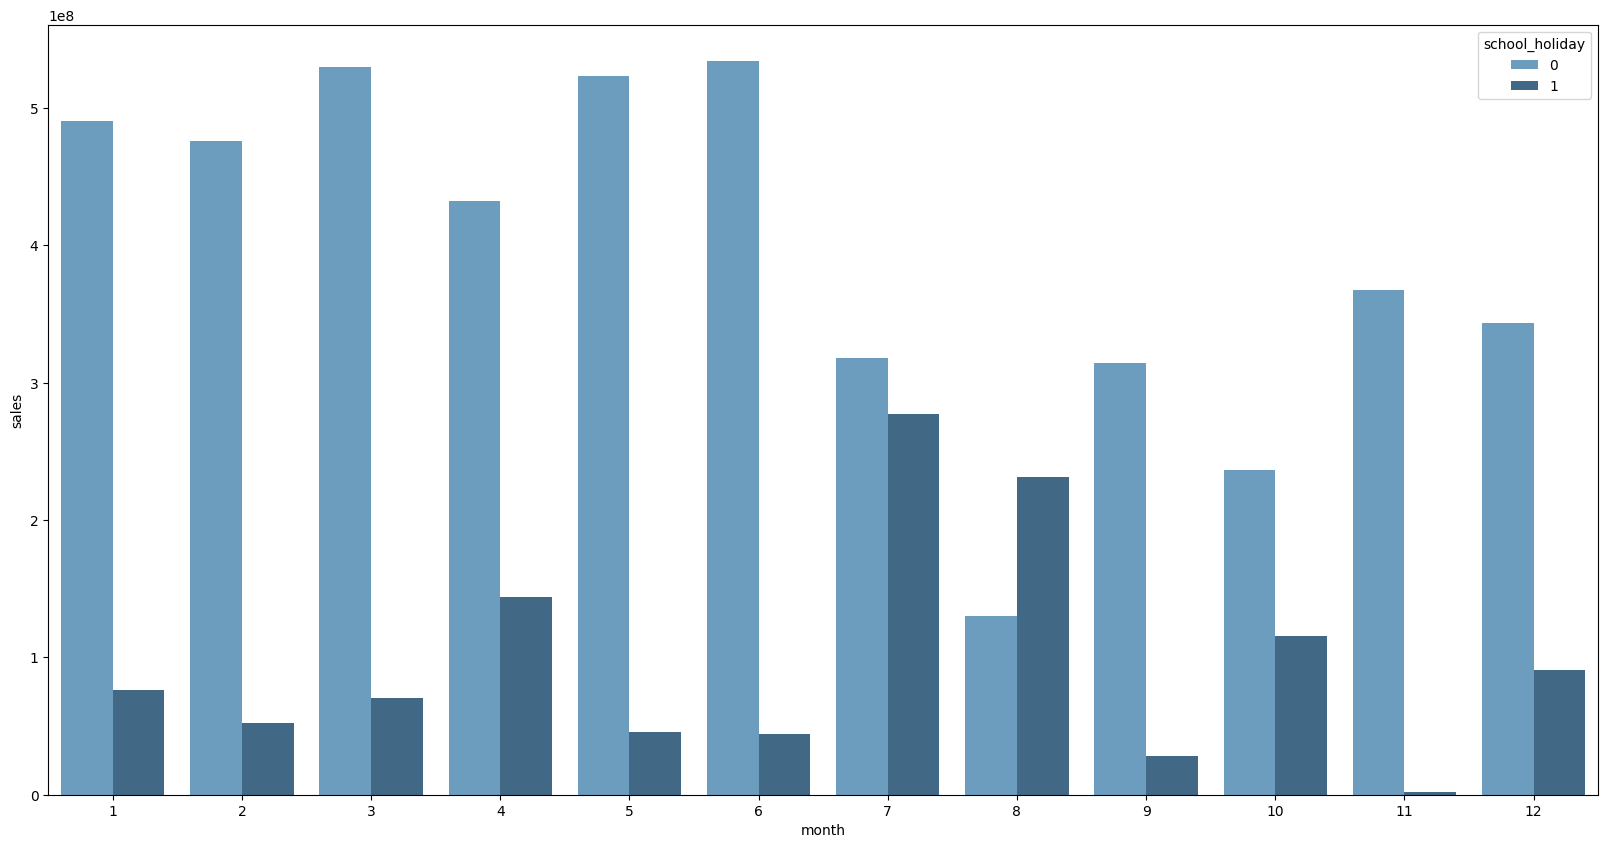

In [39]:
# Sales vs School Holiday
school = data4[['school_holiday', 'sales', 'month']].groupby(['school_holiday', 'month']).sum().reset_index()

plt.figure(figsize = (20, 10))
school_plot = sns.barplot(data = school, x = 'month', y = 'sales', hue = 'school_holiday', palette = 'Blues_d');

In general, consumers usually do not spend on school holidays (except August).  It is possible that school holidays (in July and August) are more likely to be associated with families going on vacation or parents taking time off work to spend with their children, which could lead to increase in consumer spendings.

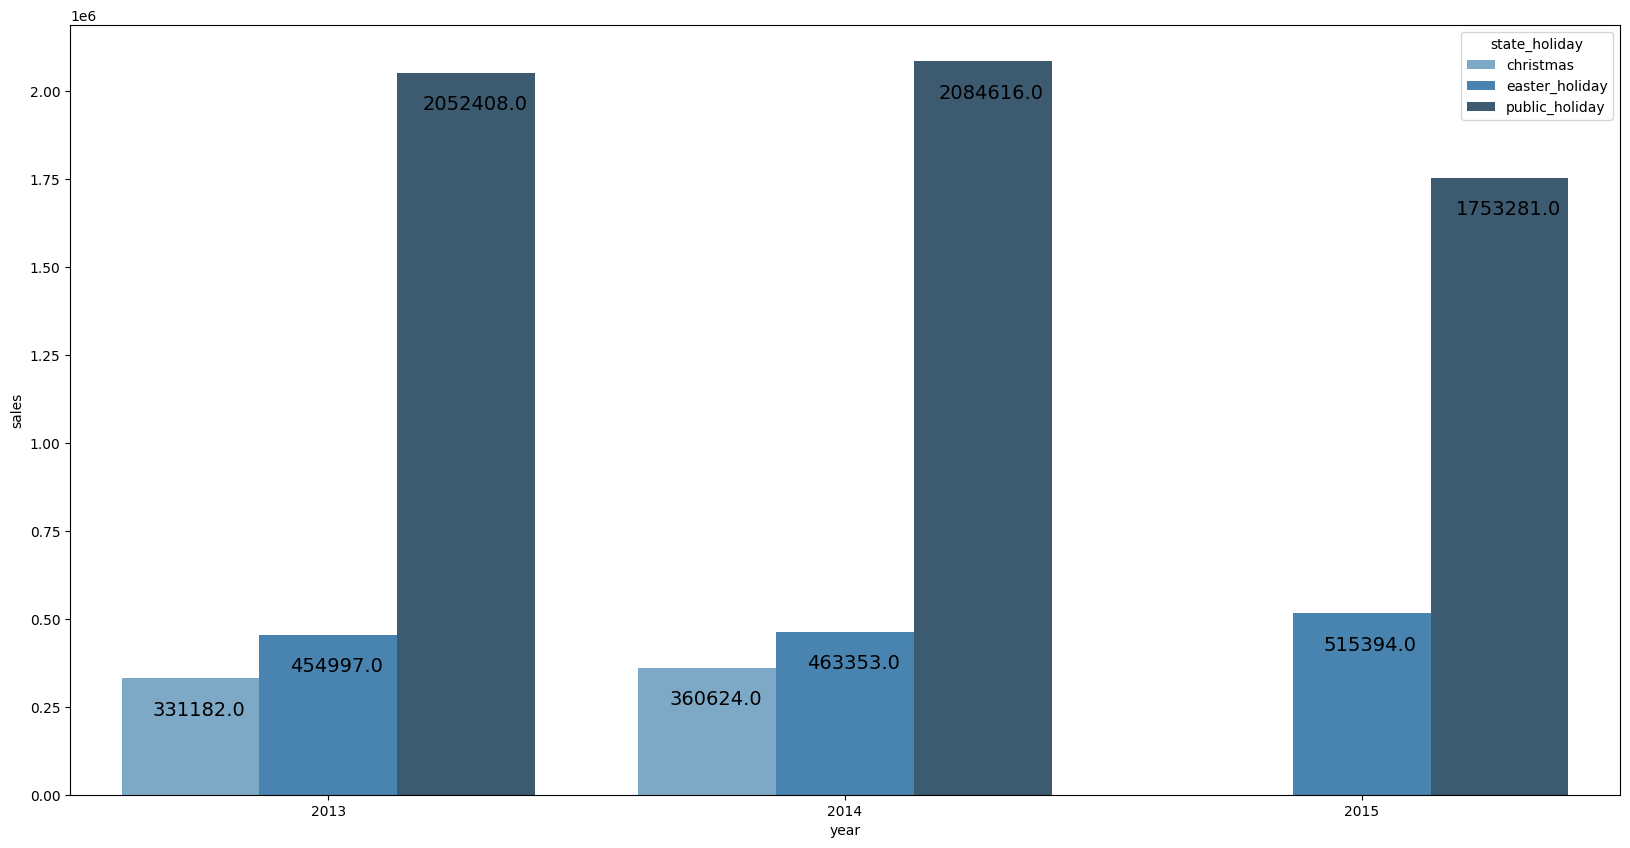

In [40]:
# Sales vs State Holiday
state = data4[data4['state_holiday'] != 'regular_day']
state_new = state[['state_holiday', 'sales','year']].groupby(['year','state_holiday']).sum().reset_index()

plt.figure(figsize = (20, 10))
state_plot = sns.barplot(x = 'year', y = 'sales', hue = 'state_holiday', data = state_new, palette = 'Blues_d')
for p in state_plot.patches:
    state_plot.annotate(f'\n{p.get_height()}', (p.get_x()+0.15, p.get_height()), ha = 'center', va = 'top', color = 'black', size = 14);

# IV. DATA PRE-PROCESSING

In [41]:
data5 = data4.copy()

## 4.1. Normalization

#### There is no normal distribution

## 4.2. Rescaling

In [42]:
data5.select_dtypes(include = ['int32', 'int64', 'datetime64[ns]']).columns

Index(['store', 'competition_distance', 'promo2', 'day_of_week', 'date',
       'sales', 'customers', 'promo', 'school_holiday', 'year_month', 'year',
       'month', 'day', 'week_of_year'],
      dtype='object')

There are 4 variables needed to be rescale:
- competition_distance
- year
- competition_time_month
- promo_time_week

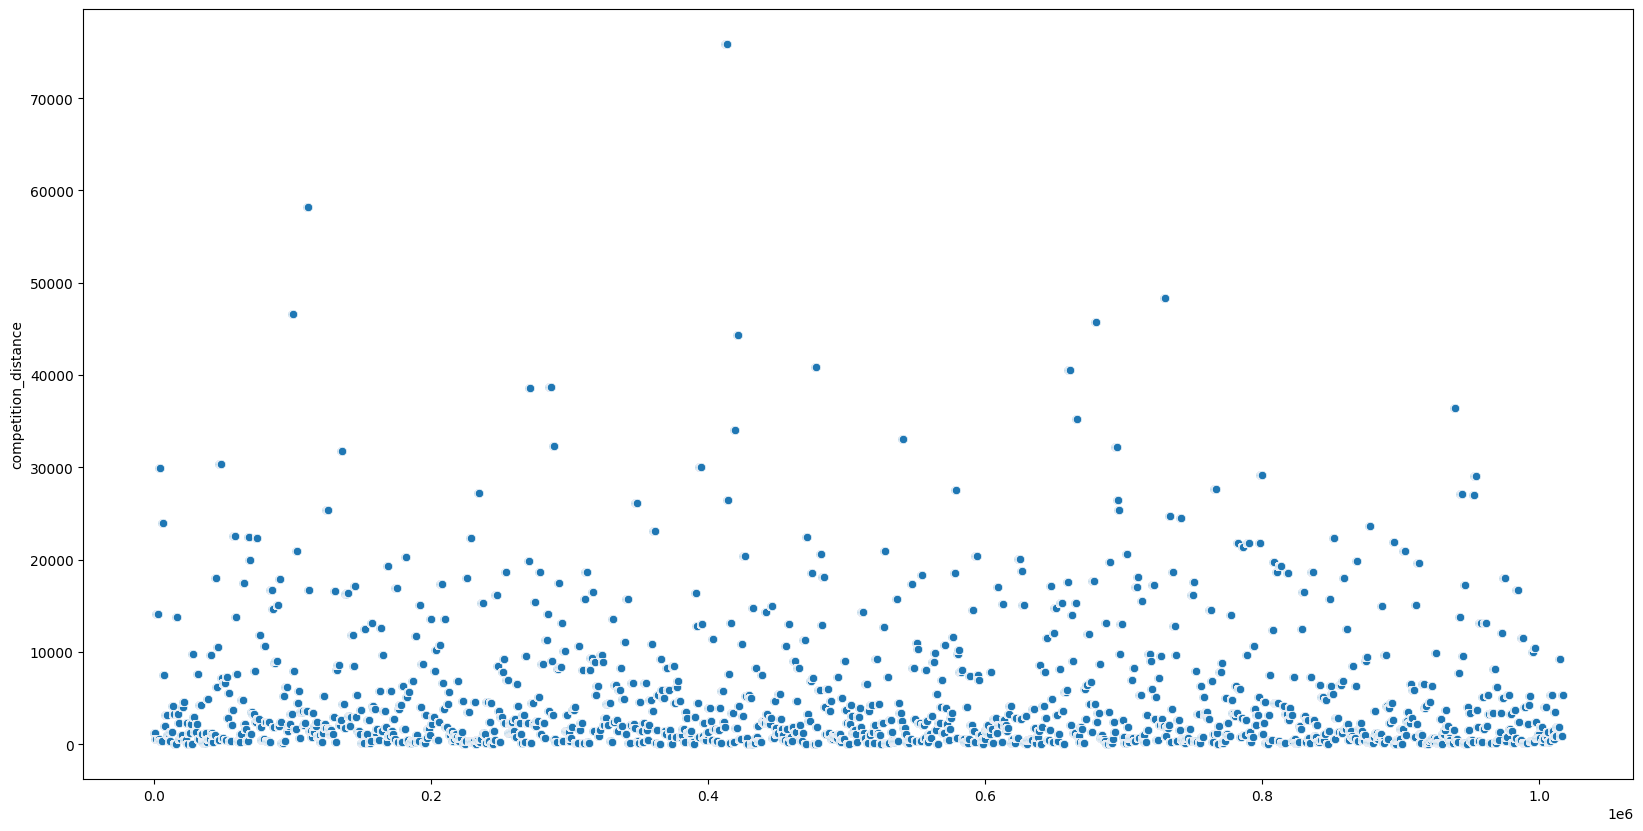

In [43]:
# Finding outliers
plt.figure(figsize = (20, 10))
sns.scatterplot(data5['competition_distance']);

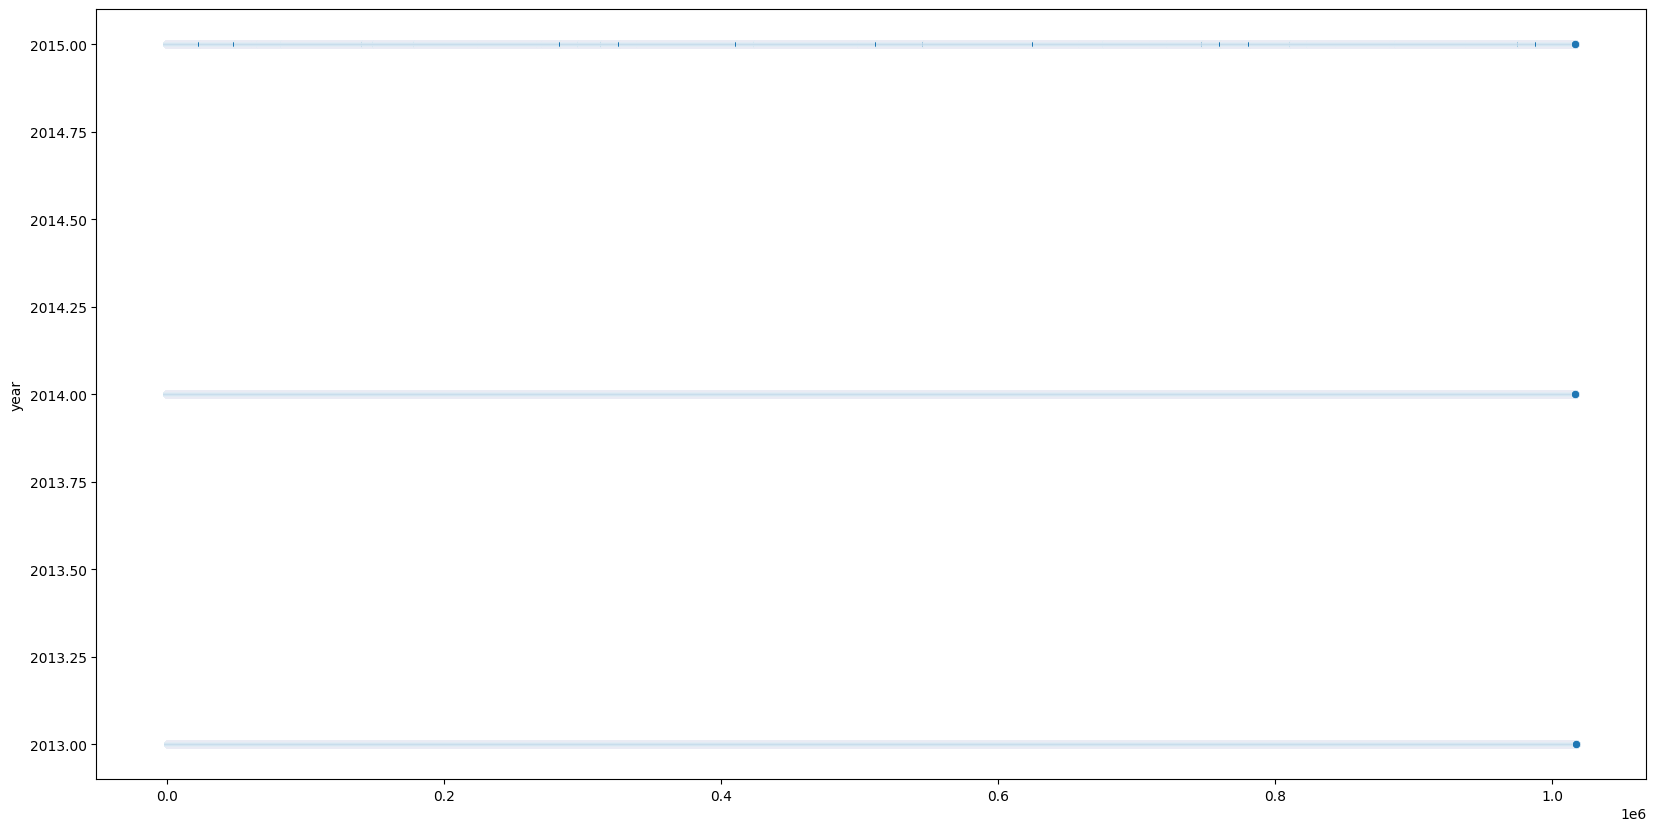

In [44]:
plt.figure(figsize = (20, 10))
sns.scatterplot(data5['year']);

In [45]:
rs = RobustScaler()
mms = MinMaxScaler()

data5['competition_distance'] = rs.fit_transform(data5[['competition_distance']].values)
data5['year'] = mms.fit_transform(data5[['year']].values)

## 4.3. Transformation

There are 3 variables need to be transform:
- state_holiday
- store_type
- assortment

In [46]:
data5['sales'] = np.log1p(data5['sales'])

In [47]:
# One Hot Encoder
data5 = pd.get_dummies(data = data5, prefix = 'state_holiday', columns = ['state_holiday'])

# Label Encoder
le = LabelEncoder()
data5['store_type'] = le.fit_transform(data5['store_type'])

assortment = {'basic' : 1, 'extra' : 2, 'extended' : 3}
data5['assortment'] = data5['assortment'].map(assortment)

# V. FEATURE SELECTION

## 5.1. Correlation between variables

In [48]:
data6 = data5.copy().reset_index()

In [49]:
data6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844338 entries, 0 to 844337
Data columns (total 23 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   index                         844338 non-null  int64         
 1   store                         844338 non-null  int64         
 2   store_type                    844338 non-null  int32         
 3   assortment                    844338 non-null  int64         
 4   competition_distance          844338 non-null  float64       
 5   promo2                        844338 non-null  int64         
 6   day_of_week                   844338 non-null  int64         
 7   date                          844338 non-null  datetime64[ns]
 8   sales                         844338 non-null  float64       
 9   customers                     844338 non-null  int64         
 10  promo                         844338 non-null  int64         
 11  school_holida

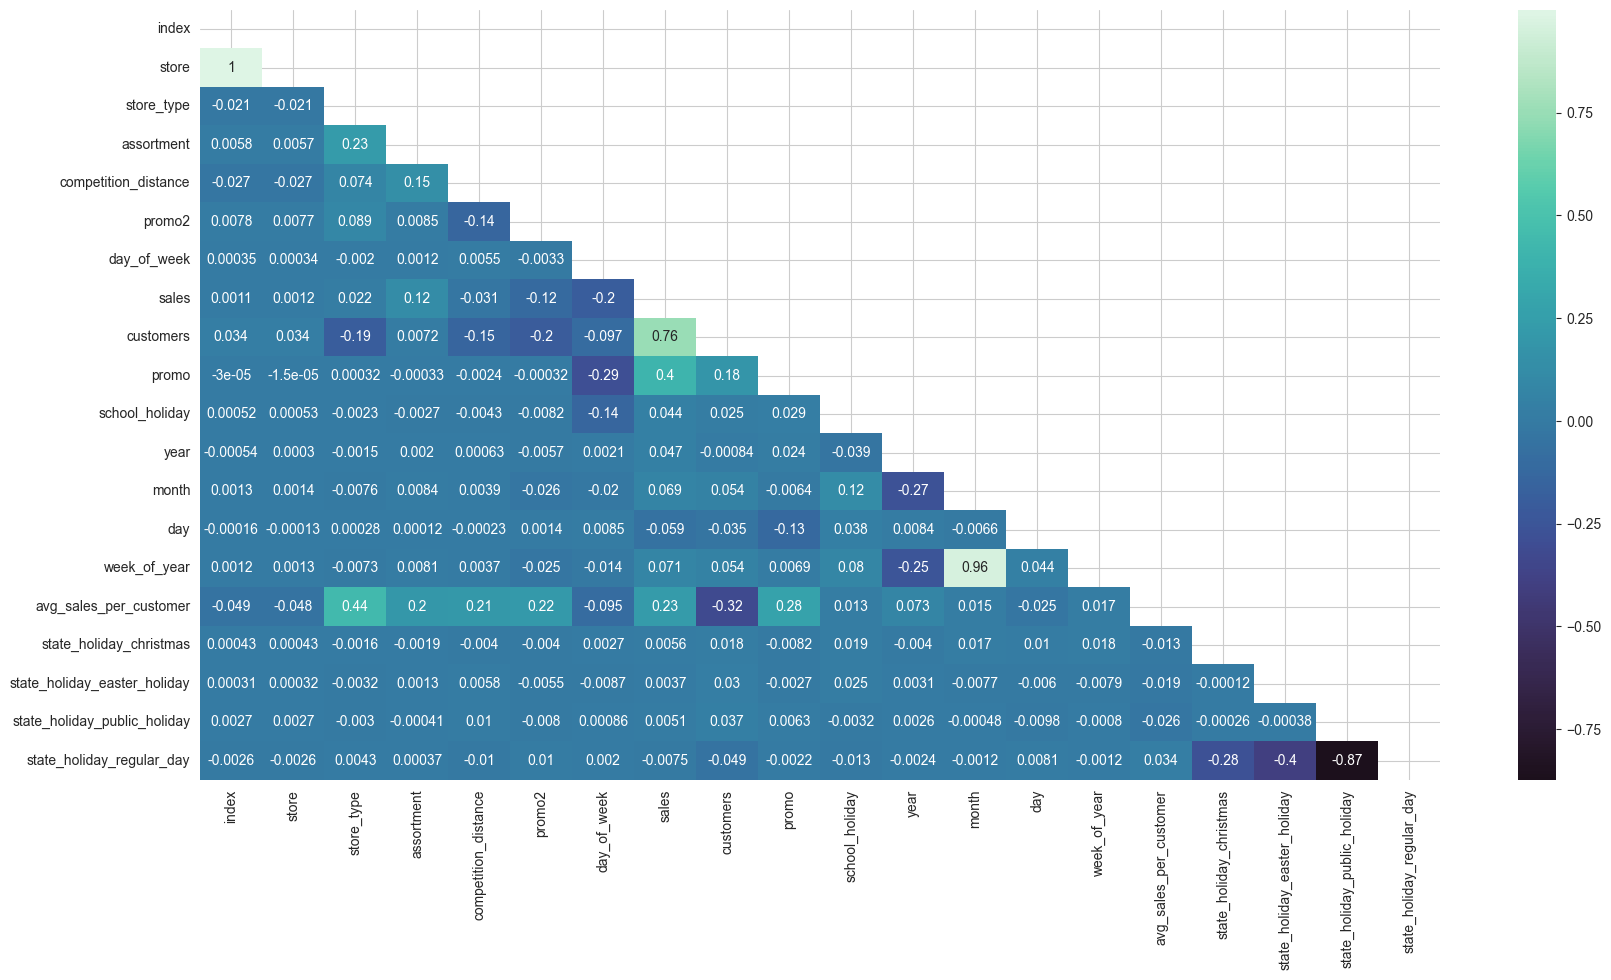

In [50]:
#style.use('ggplot')
sns.set_style('whitegrid')
plt.subplots(figsize = (20, 10))

mask = np.zeros_like(data6.corr())
mask[np.triu_indices_from(mask)] = True

sns.heatmap(data6.corr(), cmap = sns.cubehelix_palette(start=.5, rot=-.75), mask = mask, annot = True, center = 0);


## 5.2. Split data (train set and test set)

In [51]:
# Cols use to train
cols_to_use = ['promo', 'store_type', 'assortment', 'competition_distance', 'school_holiday', 'day_of_week', 
               'customers', 'month', 'year', 'week_of_year', 'promo2', 'state_holiday_christmas', 'month', 'day', 'avg_sales_per_customer', 
               'state_holiday_easter_holiday', 'state_holiday_public_holiday', 'state_holiday_regular_day']

In [52]:
X = data6[cols_to_use]
y = data6['sales']

In [53]:
# Splitting dataset into train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)


In [54]:
ss = StandardScaler()
n = Normalizer()

X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

X_train = n.fit_transform(X_train)
X_test = n.transform(X_test)

# VI. MACHINE LEARNING MODELING

## 6.1. Regression Model

In [55]:
def ml(model, y, y_hat):
    MAE = mean_absolute_error(y, y_hat),
    MAPE = mean_absolute_percentage_error(y, y_hat)
    MSE = mean_squared_error(y, y_hat),
    RMSE = sqrt(mean_squared_error(y, y_hat)),
    R2 = r2_score(y, y_hat)
    return pd.DataFrame(index = [model], data = {'MAE' : MAE,
                                                 'MAPE' : MAPE,
                                                 'MSE' : MSE, 
                                                 'RMSE' : RMSE,
                                                 'R2' : R2})

## 6.2. Linear Regression Model

In [56]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred = lr.predict(X_test)

trs1 = lr.score(X_train, y_train)
tes1 = lr.score(X_test, y_test)

lr_result = ml('Linear Regression', np.expm1(y_test), np.expm1(y_pred))
lr_result


,MAE,MAPE,MSE,RMSE,R2
Linear Regression,643.768738,0.098268,1.179291e+06,1085.951583,0.876918


## 6.3. Decision Tree Regression

In [57]:
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)
dtr.predict(X_test)

trs2 = dtr.score(X_train, y_train)
tes2 = dtr.score(X_test, y_test)

dtr_result = ml('Decision Tree Regression', np.expm1(y_test), np.expm1(y_pred))
dtr_result

,MAE,MAPE,MSE,RMSE,R2
Decision Tree Regression,643.768738,0.098268,1.179291e+06,1085.951583,0.876918


## 6.4. XGBoost

In [58]:
xgb = xgb.XGBRegressor()
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

trs3 = xgb.score(X_train, y_train)
tes3 = xgb.score(X_test, y_test)

xgb_result = ml('XGB Regressor', np.expm1(y_test), np.expm1(y_pred))
xgb_result

,MAE,MAPE,MSE,RMSE,R2
XGB Regressor,87.506505,0.013228,21433.267732,146.401051,0.997763


## 6.5. K-Nearest Neighbors

In [59]:
knn = KNeighborsRegressor(n_neighbors = 10)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

trs4 = knn.score(X_train, y_train)
tes4 = knn.score(X_test, y_test)

knn_result = ml('KNearestNeighbors', np.expm1(y_test), np.expm1(y_pred))
knn_result

,MAE,MAPE,MSE,RMSE,R2
KNearestNeighbors,514.053526,0.081464,548449.103601,740.573496,0.942759


## 6.6. Results

### 6.6.1. Model Results

In [62]:
# Model results
model_result = pd.concat([lr_result, dtr_result, xgb_result, knn_result])
model_result.sort_values('RMSE')

,MAE,MAPE,MSE,RMSE,R2
XGB Regressor,87.506505,0.013228,2.143327e+04,146.401051,0.997763
KNearestNeighbors,514.053526,0.081464,5.484491e+05,740.573496,0.942759
Linear Regression,643.768738,0.098268,1.179291e+06,1085.951583,0.876918
Decision Tree Regression,643.768738,0.098268,1.179291e+06,1085.951583,0.876918


### 6.6.2. Score Results

In [63]:
# Score results
score = pd.DataFrame({'Train Score': [trs1, trs2, trs3, trs4], 'Test Score' : [tes1, tes2, tes3, tes4]}, 
                    index = ['Linear Regression', 'Decision Tree Regression', 'XGBoost', 'K-Nearest Neighbors'])
score

,Train Score,Test Score
Linear Regression,0.901639,0.901308
Decision Tree Regression,1.000000,0.998373
XGBoost,0.997938,0.997683
K-Nearest Neighbors,0.945052,0.931057


XGBoost will be chosen to predict sales performance in this dataset.